# Softmax Classification (with Cross-Entropy Loss)

In this exercise you will:

- Implement a fully-vectorized **loss function** for the Softmax classifier
- Implement the fully-vectorized expression for its **analytic gradient**
- **Check your implementation** with numerical gradient
- Use a validation set to **tune the learning rate and regularization** strength
- **Optimize** the loss function with **SGD**
- **Visualize** the final learned weights


In [43]:
import time
import random
import math
import numpy as np
from exercise_code.model_savers import save_softmax_classifier
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


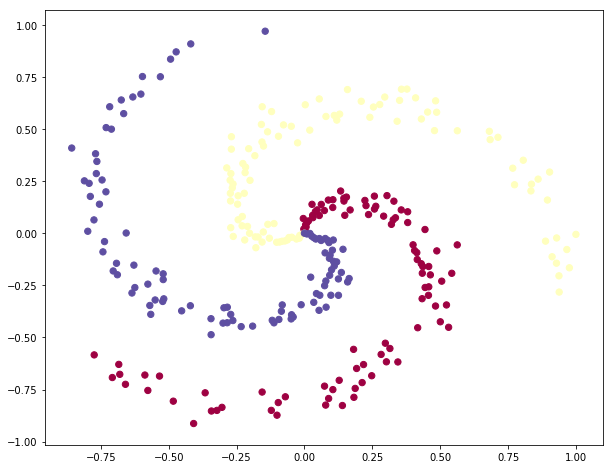

In [44]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [45]:
#Train a Linear Classifier
import numpy as np
D = 2
K = 3
# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(200):
  
  # evaluate class scores, [N x K]
    scores = np.dot(X, W) + b 
  
  # compute the class probabilities
exp_scores = np.exp(scores)
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

probs[range(num_examples),y]

array([0.33333333, 0.33327672, 0.33323379, 0.33316521, 0.33311462,
       0.33305496, 0.33299421, 0.33297545, 0.33287523, 0.33281923,
       0.33276841, 0.33270391, 0.33264627, 0.3326018 , 0.3325494 ,
       0.33247459, 0.33245614, 0.33255127, 0.33230761, 0.33226126,
       0.33237307, 0.33220293, 0.3321314 , 0.33208337, 0.33198018,
       0.33233526, 0.33213339, 0.33201299, 0.33214876, 0.33206833,
       0.33224928, 0.33182714, 0.33238935, 0.3322603 , 0.33219066,
       0.33170982, 0.33179063, 0.33194717, 0.33220853, 0.33194024,
       0.33271933, 0.33284905, 0.33288297, 0.33305197, 0.33223831,
       0.33312285, 0.33318214, 0.33335259, 0.3331299 , 0.33267338,
       0.33332565, 0.33368479, 0.33363788, 0.33399044, 0.33385312,
       0.33338808, 0.33235299, 0.33310776, 0.33582928, 0.33406138,
       0.33541079, 0.33475328, 0.33394328, 0.33550473, 0.33572654,
       0.33441552, 0.33612719, 0.33628313, 0.33586784, 0.3344841 ,
       0.33577579, 0.33672493, 0.33633951, 0.33699361, 0.33659

In [36]:
W*W

array([[1.54912722e-04, 5.09609437e-05, 3.71325254e-05],
       [4.91548406e-05, 3.82539596e-05, 8.68833240e-05]])

In [37]:
W

array([[ 0.01244639, -0.00713869, -0.00609365],
       [ 0.00701105, -0.00618498, -0.00932112]])

In [42]:
W.dot(W.T)

array([[0.00024301, 0.00018821],
       [0.00018821, 0.00017429]])

## CIFAR-10 Data Loading and Preprocessing

To your convenience, we have taken care of all the input handling. Nevertheless, you should go through the following code line by line so that you understand the general preprocessing pipeline.
The whole datasat is loaded, then subdivided into a training, validation and test dataset (the last one is different from the final evaluation dataset on our server!).

Before proceeding you should *always* take a look at some samples of your dataset, which is already implemented for you. This way you can make sure that the data input/preprocessing has worked as intended and you can get a feeling for the dataset.

In [46]:
from exercise_code.data_utils import load_CIFAR10
# Load the raw CIFAR-10 data
cifar10_dir = 'datasets/'
X, y = load_CIFAR10(cifar10_dir)

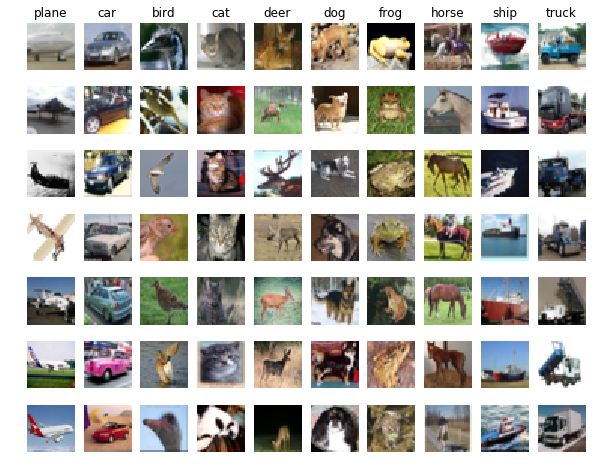

In [47]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y_hat, cls in enumerate(classes):
    idxs = np.flatnonzero(y == y_hat)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y_hat + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [48]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the data set;
# we can use this for development so our code runs faster.
num_training = 48000
num_validation = 1000
num_test = 1000
num_dev = 500

assert (num_training + num_validation + num_test) == 50000, 'You have not provided a valid data split.'

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X[mask]
y_train = y[mask]

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X[mask]
y_val = y[mask]

# We use a small subset of the training set as our test set.
mask = range(num_training + num_validation, num_training + num_validation + num_test)
X_test = X[mask]
y_test = y[mask]

# We will also make a development set, which is a small subset of
# the training set. This way the development cycle is faster.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

In [49]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (48000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64297917 135.92841667 132.4100625  130.0744375  135.3130625
 131.70479167 131.0373125  136.18741667 132.48804167 131.65420833]


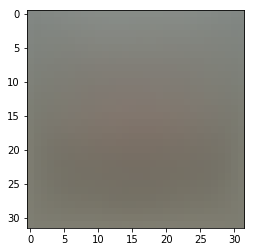

In [50]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [51]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [52]:
# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(48000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Softmax Classifier

In this section you will implement the essential elements of a softmax classifier. We will start with the cross-entropy loss and it's gradient with respect to the classifier's weights. We suggest that you first derive these expressions on paper.

### Naive Implementation
First implement a naive cross-entropy loss function with nested loops. Open the file `exercise_code/classifiers/softmax.py` and implement the loss of the softmax classifier into the `cross_entropoy_loss_naive` function.

Running this method might take a while...

In [53]:
from exercise_code.classifiers.softmax import cross_entropoy_loss_naive

# Generate a random weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = cross_entropoy_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.356872
sanity check: 2.302585


In [ ]:
"""W = np.random.randn(3073, 10) * 0.0001

for i in range(X_dev.shape[0]):
        score = X_dev[i].dot(W)
    
        nominator = np.exp(score)
        denominator = np.sum(nominator)
    
        p = nominator / denominator 
        log_p = np.log(p)
    
    

        log_likelihood = -np.log(p[y_dev[i]])
        loss+=log_likelihood
        print(p)
        print (p[y_dev[i]])
        print(y_dev[i])
        scores = np.exp(X_dev.dot(W)) / np.sum(np.exp(X_dev.dot(W)))
        print(scores[0])
        #print(np.exp(score))
        #print(np.exp(X_dev.dot(W))[0])
        print(denominator)
        print(np.sum(np.exp(X_dev.dot(W)), axis=1, keepdims=True)[0])
        assert(1 == 0)
"""

In [10]:
loss = 0.0
log_likelihood = 0.0
W = np.random.randn(3073, 10) * 0.0001
n = X_dev.shape[0]

scores = X_dev.dot(W)
nominator = np.exp(scores)
denom = np.sum(nominator,axis=1, keepdims=True)
prob = nominator / denom
#prob = np.exp(scores) / np.sum(np.exp(scores))
#prob[:,y_dev]
ll = prob[np.arange(n),y_dev]
log_likelihood = -np.log(ll)
loss = np.sum(log_likelihood) / n
loss
#log_likelihood

2.4041099958996885

In [11]:
you = X_dev.dot(W)
you
maxx = np.amax(you, axis=1)
np.max(you[256])

0.16170787120908489

In [ ]:
maxx[256]

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Why do we expect our loss to be close to -log(0.1)? Explain briefly.</p>
</div>

Since we have 10 classes, the probability of choosing the correct one given an even distribution would be 1/10 or .1. Since the loss formula is formulated by -log(probability). We hope that our likelihood is at least -log(.1)


Complete the implementation of the `cross_entropoy_loss_naive` function and implement a (naive) version of the gradient that uses nested loops. Use the following cell to check your results:

In [13]:
from exercise_code.gradient_check import grad_check_sparse
# We take a smaller dev set since the naive implementation takes quite some while
X_dev_small, y_dev_small = X_dev[:10], y_dev[:10]

loss, grad = cross_entropoy_loss_naive(W, X_dev_small, y_dev_small, 0.0)

# We use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
f = lambda w: cross_entropoy_loss_naive(W, X_dev_small, y_dev_small, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)
print(grad_numerical)
# Again, running this might take a while!

numerical: 7.1941332615566 analytic: 7.194133168005051, relative error: 6.5019333688379875e-09
numerical: 13.239865592051812 analytic: 13.239865811947322, relative error: 8.304295328605154e-09
numerical: -0.7243072843943209 analytic: -0.7243075669322575, relative error: 1.950400662698794e-07
None


In [14]:
# Do another gradient check with regularization
loss, grad = cross_entropoy_loss_naive(W, X_dev_small, y_dev_small, 1e2)
f = lambda w: cross_entropoy_loss_naive(w, X_dev_small, y_dev_small, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

numerical: 4.0348976675153025 analytic: 4.034897157151278, relative error: 6.32437423637343e-08
numerical: -1.0290311060590085 analytic: -1.0290316020327577, relative error: 2.409905914098752e-07
numerical: 1.01668637908503 analytic: 1.016686458627683, relative error: 3.9118577485399095e-08


### Vectorized Implementation
Now that we have a naive implementation of the cross-entropy loss and its gradient, implement a vectorized version in `cross_entropoy_loss_vectorized`.

The two versions should compute the same results, but the vectorized version should be much faster.

In [54]:
from exercise_code.classifiers.softmax import cross_entropoy_loss_vectorized

tic = time.time()
loss_naive, grad_naive = cross_entropoy_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = cross_entropoy_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.356872e+00 computed in 15.488608s
vectorized loss: 2.356872e+00 computed in 0.005985s
Loss difference: 0.000000
Gradient difference: 0.000000


In [58]:
loss_vectorized, grad_vectorized = cross_entropoy_loss_vectorized(W, X_dev, y_dev, 0.00001)


[[-1.77846101e-03  1.49200503e-04  2.71990284e-04 ...  1.93853749e-04
   1.26216364e-04  1.90155025e-04]
 [ 2.90359938e-04  1.90560573e-04  6.82893267e-05 ...  2.22981381e-04
   1.28716733e-04  4.44513385e-04]
 [ 1.55028123e-04  2.59739345e-04  1.20315069e-04 ...  3.20164619e-04
   2.15013674e-04  1.82527456e-04]
 ...
 [ 2.04328667e-04  1.91778639e-04 -1.85740803e-03 ...  1.85515352e-04
   2.70522752e-04  1.65259172e-04]
 [ 1.75535526e-04  1.48095598e-04 -1.65124282e-03 ...  1.21253549e-04
   2.93048125e-04  1.06954883e-04]
 [-1.88052603e-03  1.67992531e-04  2.19491621e-04 ...  2.15154860e-04
   2.21085687e-04  9.30213275e-05]]


<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>When you compute the softmax distribution, you are dividing by a sum of exponentials, i.e. potentially very large numbers, which can be numerically unstable. Do you see a way to avoid this problem?
</p>
    <p>(Hint: exploit properties of the exponential function to arrive at an expression that is mathematically the same, but numerically more stable)</p>
</p>
</div>

*Since we are dealing with a ratio, we can simply reduce the total value of each exponential by subtracting a constant. For example, instead of calcuating e^x, we can calculate e^x - m where m is an arbitrary number (biggest possible). If we do this with all values, then the ratio will remain the same. This is just like normalization.* 


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to usw SGD to minimize the loss. In the file `exercise_code/classifiers/linear_classifier.py`, implement SGD in the `LinearClassifier.train` method and test it with the code below.

In [15]:
from exercise_code.classifiers.softmax import SoftmaxClassifier

# The SoftmaxClassifier class inherits from LinearClassifier
softmax = SoftmaxClassifier()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                          num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 774.852153
iteration 100 / 1500: loss 284.499335
iteration 200 / 1500: loss 105.442296
iteration 300 / 1500: loss 39.918502
iteration 400 / 1500: loss 15.947838
iteration 500 / 1500: loss 7.186981
iteration 600 / 1500: loss 3.931691
iteration 700 / 1500: loss 2.712114
iteration 800 / 1500: loss 2.379198
iteration 900 / 1500: loss 2.182807
iteration 1000 / 1500: loss 2.129709
iteration 1100 / 1500: loss 2.070319
iteration 1200 / 1500: loss 2.100847
iteration 1300 / 1500: loss 2.071569
iteration 1400 / 1500: loss 2.108015
That took 8.286263s


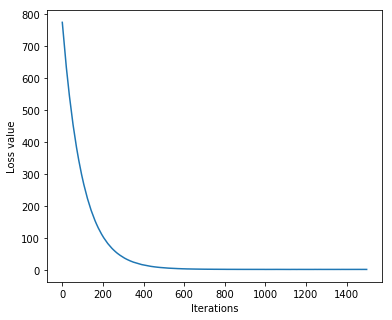

In [16]:
# A useful debugging strategy is to plot the loss as a function of iterations:
plt.figure(figsize=(6,5))
plt.plot(loss_hist)
plt.xlabel('Iterations')
plt.ylabel('Loss value')
plt.show()

Write the `LinearClassifier.predict` method and evaluate the performance on both the training and validation set:

In [17]:
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.329646
validation accuracy: 0.327000


In [ ]:
y_train_pred

yyy = {}
"""
yyy.append((.3,3,1))
yyy.append((.8,2,3))
yyy.append((10,8,2))
"""

yyy[(1,2)] = (3,4)
yyy[(1,2)] = (8,9)

In [ ]:
#m = np.max([i[2] for i in yyy])
dict([('hi','goodbye')])
#yyy([('hi','goodbye')])
yyy[(1,2)]

### Training your Softmax Classifier
Use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths; if you are careful you should be able to get a classification accuracy of over 0.35 on the validation set. Implement the `softmax_hyperparameter_tuning` function in `exercise_code/classifiers/softmax.py`.

In [18]:
from exercise_code.classifiers.softmax import SoftmaxClassifier, softmax_hyperparameter_tuning

best_softmax, results, all_classifiers = softmax_hyperparameter_tuning(X_train, y_train, X_val, y_val)

iteration 0 / 1500: loss 158.999004
iteration 100 / 1500: loss 129.063426
iteration 200 / 1500: loss 105.666861
iteration 300 / 1500: loss 86.180819
iteration 400 / 1500: loss 70.847073
iteration 500 / 1500: loss 58.504008
iteration 600 / 1500: loss 47.942697
iteration 700 / 1500: loss 39.461698
iteration 800 / 1500: loss 32.635063
iteration 900 / 1500: loss 26.987445
iteration 1000 / 1500: loss 22.475098
iteration 1100 / 1500: loss 18.685634
iteration 1200 / 1500: loss 15.661359
iteration 1300 / 1500: loss 13.196112
iteration 1400 / 1500: loss 11.101774
iteration 0 / 1500: loss 158.363678
iteration 100 / 1500: loss 95.313234
iteration 200 / 1500: loss 58.370680
iteration 300 / 1500: loss 36.025604
iteration 400 / 1500: loss 22.509884
iteration 500 / 1500: loss 14.248118
iteration 600 / 1500: loss 9.411644
iteration 700 / 1500: loss 6.525285
iteration 800 / 1500: loss 4.663292
iteration 900 / 1500: loss 3.537794
iteration 1000 / 1500: loss 2.887165
iteration 1100 / 1500: loss 2.507230


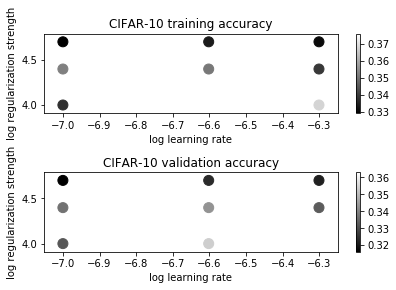

In [19]:
# Visualize the validation results
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

plt.tight_layout()
plt.show()

In [20]:
# if you want to take a look at the other classifiers assign them to best_softmax here
sorted_classifiers = sorted(all_classifiers, key=lambda x : x[1])
best_softmax = sorted_classifiers[-1][0]

TypeError: 'SoftmaxClassifier' object does not support indexing

In [21]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.370000


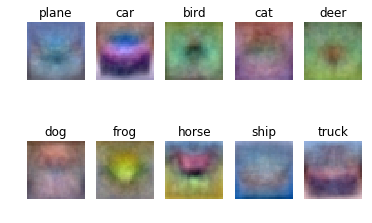

In [22]:
# Visualize the learned weights for each class
#best_softmax = sorted_classifiers[idx][0]
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe what your visualized Softmax weights look like.</p>
    
    It looks like there are giant bulges in the middle. However, the basic outline of the animals can be seen from the images. This shows that the softmax classifier is good at learning the basic shape of the classes. However, the images themselves are not too descriptive and so it makes sense that it's accurachy is not too reliable. (A lot of the images look similiar). 
</div>

## Save the model

When you are satisfied with your training, save the model for submission. Your final score is computed by `accuracy * 100`. In order to pass this exercise, you have to achieve a score higher than __35__.

<div class="alert alert-danger">
    <h3>Warning</h3>
    <p>You might get an error like this:</p>
    <p>PicklingError: Can't pickle `<class 'exercise_code.classifiers.softmax.SoftmaxClassifier'>`: it's not the same object as exercise_code.classifiers.softmax.SoftmaxClassifier</p>
    <p>The reason is that we are using autoreload and working on this class during the notebook session. If you get this error simply restart the kernel and rerun the whole script (Kernel -> Restart & Run All) or only the important cells for generating your model.</p>
</div>

In [23]:
from exercise_code.model_savers import save_softmax_classifier
from exercise_code.classifiers.softmax import SoftmaxClassifier

save_softmax_classifier(best_softmax)